In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing #Dataset
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy.stats import skew, shapiro

# 1. Load Dataset

In [ ]:
california = fetch_california_housing(as_frame=True)
df = california.frame

In [ ]:
# Add target column
df['MedHouseVal'] = california.target

In [ ]:
# Dataset Info
print("Dataset Shape:", df.shape)
print("Columns:", df.columns)

Dataset Shape: (20640, 9)
Columns: Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')


In [ ]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# 2. Train/Test Split

In [ ]:
X = df.drop(columns=['MedHouseVal', 'Longitude'])  # Dropping Longitude due to redundancy
y = df['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Preprocessing

In [ ]:
# Standardize column names
X_train.columns = X_train.columns.str.strip().str.lower()
X_test.columns = X_test.columns.str.strip().str.lower()

## Handle missing values (none in this dataset)

In [ ]:
X_train.isna().sum()

,0
medinc,0
houseage,0
averooms,0
avebedrms,0
population,0
aveoccup,0
latitude,0


In [ ]:
X_test.isna().sum()

,0
medinc,0
houseage,0
averooms,0
avebedrms,0
population,0
aveoccup,0
latitude,0


## Scaling

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_scaled

array([[-0.326196  ,  0.34849025, -0.17491646, ...,  0.76827628,
         0.05137609, -1.3728112 ],
       [-0.03584338,  1.61811813, -0.40283542, ..., -0.09890135,
        -0.11736222, -0.87669601],
       [ 0.14470145, -1.95271028,  0.08821601, ..., -0.44981806,
        -0.03227969, -0.46014647],
       ...,
       [-0.49697313,  0.58654547, -0.60675918, ...,  0.28983345,
         0.02030568, -0.75500738],
       [ 0.96545045, -1.07984112,  0.40217517, ...,  0.30830275,
         0.00707608,  0.90651045],
       [-0.68544764,  1.85617335, -0.85144571, ...,  1.04883375,
        -0.08535429,  0.99543676]])

In [ ]:
# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# 4. EDA — Univariate


--- EDA: Univariate Analysis ---

Feature: medinc
 - Skewness: 1.63
 - Outliers detected: 529


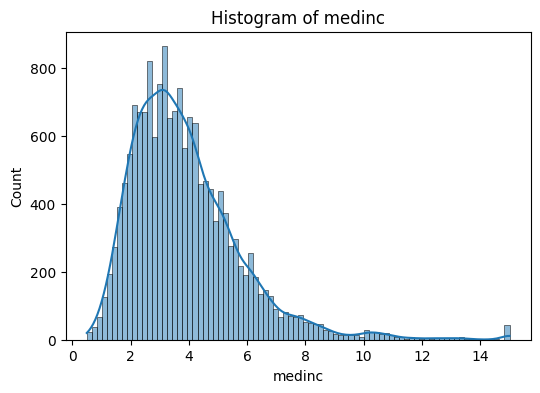

Feature: houseage
 - Skewness: 0.06
 - Outliers detected: 0


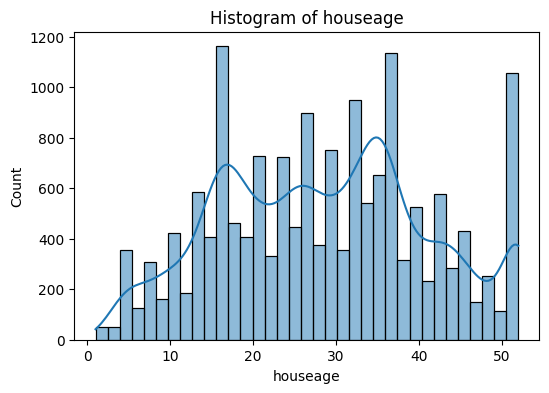

Feature: averooms
 - Skewness: 18.61
 - Outliers detected: 410


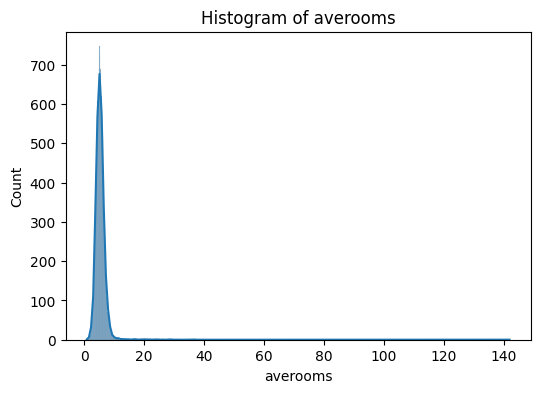

Feature: avebedrms
 - Skewness: 23.17
 - Outliers detected: 1153


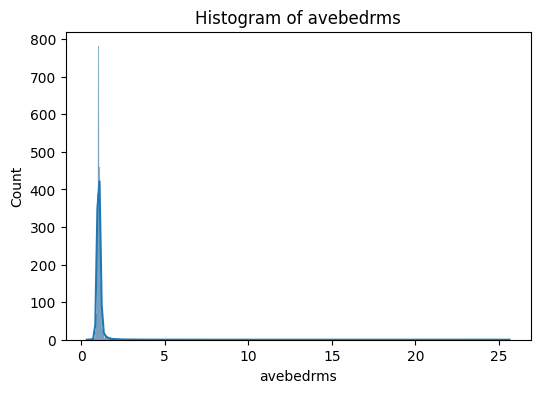

Feature: population
 - Skewness: 5.28
 - Outliers detected: 955


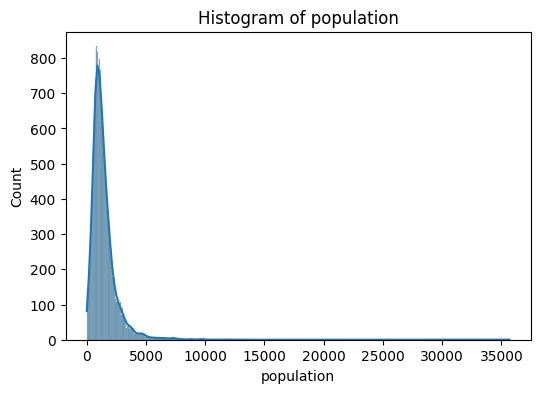

Feature: aveoccup
 - Skewness: 88.04
 - Outliers detected: 582


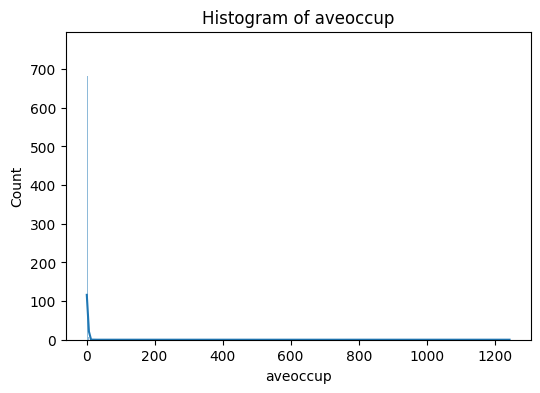

Feature: latitude
 - Skewness: 0.46
 - Outliers detected: 0


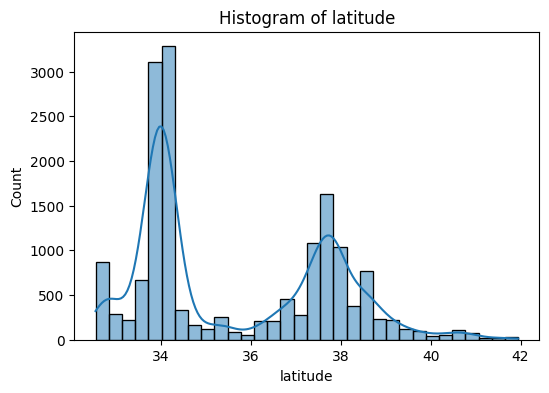

In [ ]:
print("\n--- EDA: Univariate Analysis ---\n")
eda_summary = []
for col in X_train.columns:
    feature_data = X_train[col]
    skewness = skew(feature_data)
    q1 = feature_data.quantile(0.25)
    q3 = feature_data.quantile(0.75)
    iqr = q3 - q1
    outliers = ((feature_data < (q1 - 1.5 * iqr)) | (feature_data > (q3 + 1.5 * iqr))).sum()

    print(f"Feature: {col}")
    print(f" - Skewness: {skewness:.2f}")
    print(f" - Outliers detected: {outliers}")

    eda_summary.append((col, skewness, outliers))

    # Plot histogram
    plt.figure(figsize=(6, 4))
    sns.histplot(feature_data, kde=True)
    plt.title(f'Histogram of {col}')
    plt.show()

# 5. EDA — Multivariate


--- EDA: Multivariate Analysis ---

Correlation with target variable:
medinc        0.690647
averooms      0.158485
latitude     -0.142983
houseage      0.103706
avebedrms    -0.051351
population   -0.026032
aveoccup     -0.022030
dtype: float64


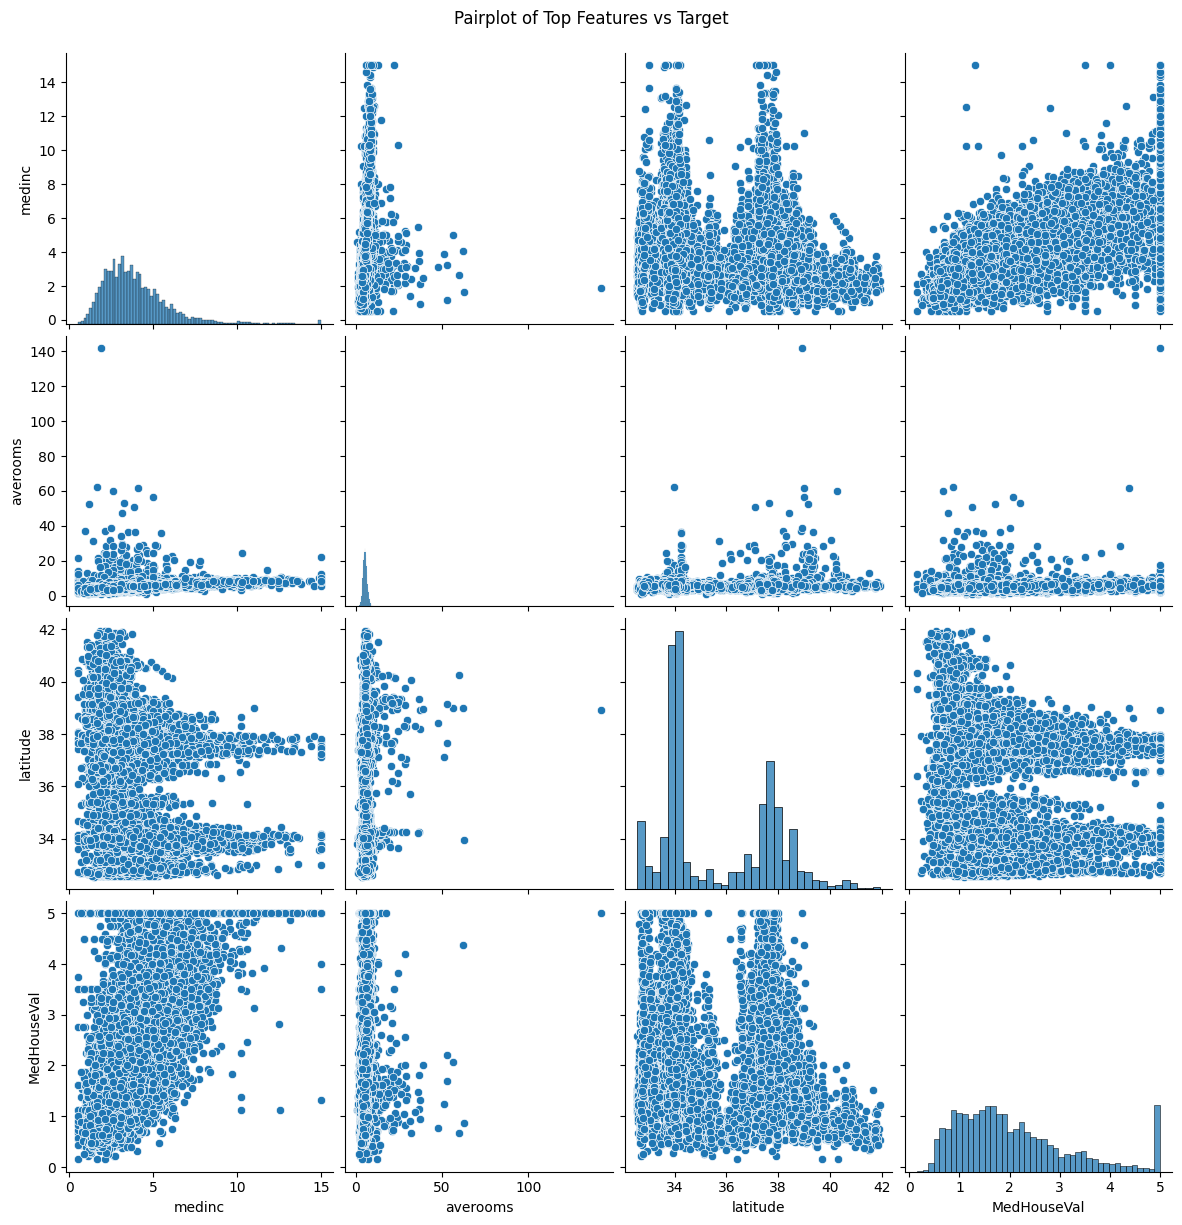

In [ ]:
print("\n--- EDA: Multivariate Analysis ---\n")
corr_matrix = X_train.corrwith(y_train).sort_values(key=abs, ascending=False)
print("Correlation with target variable:")
print(corr_matrix)

# Plot top correlated features
top_features = corr_matrix.index[:3]
sns.pairplot(pd.concat([X_train[top_features], y_train], axis=1), height=3)
plt.suptitle("Pairplot of Top Features vs Target", y=1.02)
plt.show()

# 6. Multicollinearity (VIF)

In [ ]:
X_scaled_with_const = sm.add_constant(X_train_scaled)
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled_with_const.values, i + 1)
                   for i in range(len(X_train_scaled.columns))]
print("\nVIF Scores:\n", vif_data.sort_values(by="VIF", ascending=False))


VIF Scores:
       feature       VIF
2    AveRooms  7.420153
3   AveBedrms  6.445369
0      MedInc  2.211507
1    HouseAge  1.145249
4  Population  1.128803
6    Latitude  1.065604
5    AveOccup  1.008205


# 7. Linear Regression

In [ ]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

## Predictions

In [ ]:
y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, model.predict(X_train_scaled))
train_test_gap = abs(r2_train - r2)

In [ ]:
print("\nLinear Regression Metrics:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")
print(f"R² (Test): {r2:.4f}, R² (Train): {r2_train:.4f}, Gap: {train_test_gap:.4f}")


Linear Regression Metrics:
MAE: 0.5786, MSE: 0.6370, RMSE: 0.7981
R² (Test): 0.5139, R² (Train): 0.5488, Gap: 0.0349


## Top Coefficients

In [ ]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)
print("\nTop Coefficients:\n", coef_df.head(5))


Top Coefficients:
      Feature  Coefficient
0     MedInc     1.021674
2   AveRooms    -0.500259
3  AveBedrms     0.457436
1   HouseAge     0.211147
6   Latitude    -0.063903


# 8. Polynomial Features on 'MedInc'

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled[['MedInc']])
X_test_poly = poly.transform(X_test_scaled[['MedInc']])
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
poly_pred = poly_model.predict(X_test_poly)
poly_r2 = r2_score(y_test, poly_pred)
print(f"\nPolynomial Features R² on MedInc (degree=2): {poly_r2:.4f}")


Polynomial Features R² on MedInc (degree=2): 0.4633


# 9. Regularization - Ridge

In [ ]:
ridge = Ridge()
ridge_params = {'alpha': [0.1, 1, 10]}
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5)
ridge_cv.fit(X_train_scaled, y_train)
print("\nRidge Best Alpha:", ridge_cv.best_params_)
print("Ridge CV Best R²:", ridge_cv.best_score_)


Ridge Best Alpha: {'alpha': 10}
Ridge CV Best R²: 0.5453294600875853


# 10. Regularization - Lasso

In [ ]:
lasso = Lasso(max_iter=10000)
lasso_params = {'alpha': [0.01, 0.1, 1]}
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5)
lasso_cv.fit(X_train_scaled, y_train)
print("\nLasso Best Alpha:", lasso_cv.best_params_)
print("Lasso CV Best R²:", lasso_cv.best_score_)
print("Lasso Non-zero Coefficients:", np.sum(lasso_cv.best_estimator_.coef_ != 0))


Lasso Best Alpha: {'alpha': 0.01}
Lasso CV Best R²: 0.5431650573647581
Lasso Non-zero Coefficients: 7


# 11. Cross-Validation

In [ ]:
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
cv_rmse_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("\nCross-Validation R² Mean:", np.mean(cv_scores))
print("Cross-Validation R² Std:", np.std(cv_scores))
print("Cross-Validation RMSE Mean:", np.mean(-cv_rmse_scores))
print("Cross-Validation RMSE Std:", np.std(-cv_rmse_scores))


Cross-Validation R² Mean: 0.5452790835152488
Cross-Validation R² Std: 0.011235367185291133
Cross-Validation RMSE Mean: 0.7794175506647967
Cross-Validation RMSE Std: 0.009467459128572457


# 12. Final Summary

In [ ]:
print("\nFinal Model: Ridge Regression with alpha =", ridge_cv.best_params_['alpha'])
print("Top Features by Coefficient Magnitude:\n", coef_df.head(3))
print("Test Metrics - MAE:", mae, "RMSE:", rmse, "R²:", r2)


Final Model: Ridge Regression with alpha = 10
Top Features by Coefficient Magnitude:
      Feature  Coefficient
0     MedInc     1.021674
2   AveRooms    -0.500259
3  AveBedrms     0.457436
Test Metrics - MAE: 0.5785623443830116 RMSE: 0.7981366608800815 R²: 0.5138753320387439
